Number of FLIR RGB images:  10319
Number of FLIR Thermal images:  10742
Number of LLVIP RGB images:  12025
Number of LLVIP Thermal images:  12025
Loading annotations into memory...
Done (t=0.15s)
Creating index...
index created!


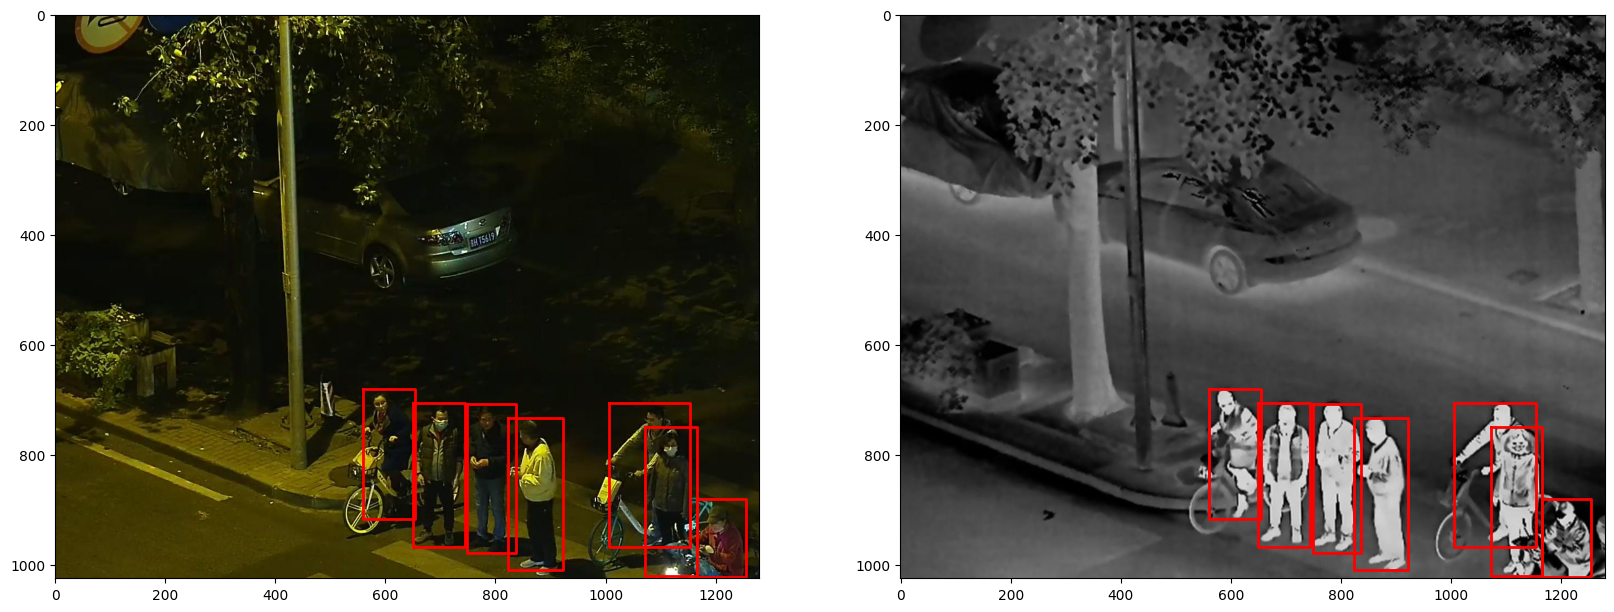

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO

flir_path = '../data/FLIR/'
llvip_path = '../data/LLVIP/'

flir_rgbimages = os.listdir(flir_path + 'images_rgb_train/data')
flir_thermalimages = os.listdir(flir_path + 'images_thermal_train/data')
llvip_rgbimages = os.listdir(llvip_path + 'visible/train')
llvip_thermalimages = os.listdir(llvip_path + 'infrared/train')

print('Number of FLIR RGB images: ', len(flir_rgbimages))
print('Number of FLIR Thermal images: ', len(flir_thermalimages))

print('Number of LLVIP RGB images: ', len(llvip_rgbimages))
print('Number of LLVIP Thermal images: ', len(llvip_thermalimages))

llvip = COCO(llvip_path + 'LLVIP.json') # load the dataset
llvip_ids = llvip.getImgIds()
img_obj = llvip.loadImgs([llvip_ids[1]])
anns_obj = llvip.loadAnns(llvip.getAnnIds(imgIds=[llvip_ids[1]]))


rgb_img = Image.open(llvip_path + 'visible/train/' + img_obj[0]['file_name'])
ir_img = Image.open(llvip_path + 'infrared/train/' + img_obj[0]['file_name'])

def plot_bbox(img, anns):
    # draw bounding boxes
    for ann in anns:
        x, y, w, h = ann['bbox']
        plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], linewidth=2, color='r')

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
# draw bounding boxes
plot_bbox(rgb_img, anns_obj)
plt.subplot(1,2,2)
plt.imshow(ir_img)
# draw bounding boxes
plot_bbox(ir_img, anns_obj)
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input shape: torch.Size([1, 3, 1024, 1280])
DCT shape: torch.Size([1, 3, 1024, 1280])
Masked DCT shape: torch.Size([1, 3, 1024, 1280])
Output shape: torch.Size([1, 3, 1024, 1280])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


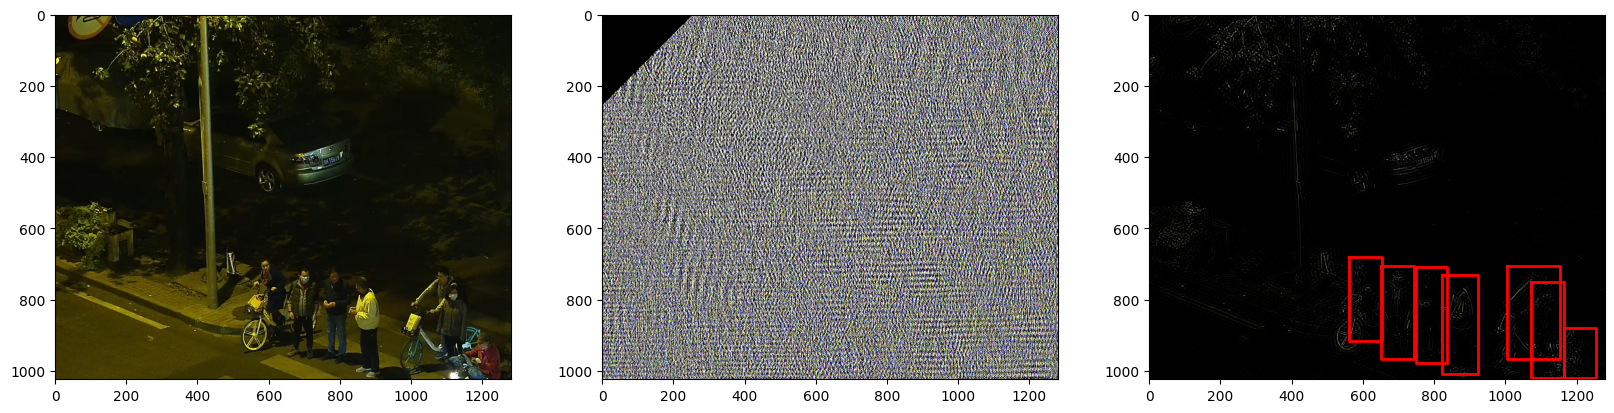

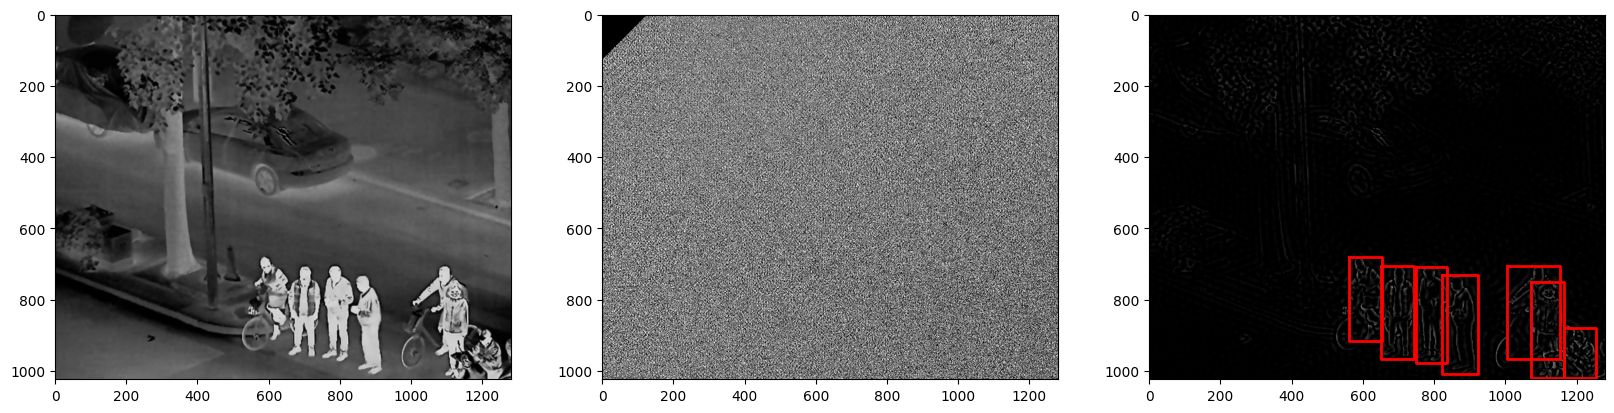

In [2]:
import torch
from torchvision import transforms
import tools.dct as dct_tools
import matplotlib.gridspec as gridspec
transforms = transforms.Compose([transforms.ToTensor()])

def plot_dct(input, masked_freq, output):
    gs = gridspec.GridSpec(1, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(gs[0,0])
    input = input.squeeze(0).permute(1,2,0)
    plt.imshow(input)
    plt.subplot(gs[0,1])
    masked_freq = masked_freq.squeeze(0).permute(1,2,0)
    plt.imshow(masked_freq)
    plt.subplot(gs[0,2])
    output = output.squeeze(0).permute(1,2,0)
    plt.imshow(output)

rgb_tensor = transforms(rgb_img).unsqueeze(0)
print(f'Input shape: {rgb_tensor.shape}')
dct_tensor = dct_tools.dct_2d(rgb_tensor)
print(f'DCT shape: {dct_tensor.shape}')
masked_tensor = dct_tools.mask_image(dct_tensor, 0.1)
print(f'Masked DCT shape: {masked_tensor.shape}')
masked_rgb = dct_tools.idct_2d(masked_tensor)
print(f'Output shape: {masked_rgb.shape}')

plot_dct(rgb_tensor, masked_tensor, masked_rgb)
plot_bbox(rgb_tensor, anns_obj)

ir_tensor = transforms(ir_img).unsqueeze(0)

dct_tensor = dct_tools.dct_2d(ir_tensor)

masked_tensor = dct_tools.mask_image(dct_tensor, 0.05)

masked_ir = dct_tools.idct_2d(masked_tensor)

plot_dct(ir_tensor, masked_tensor, masked_ir)
plot_bbox(ir_tensor, anns_obj)

In [4]:
from model import DCT2d, IDCT2d

dct_masked = DCT2d(mask_freq=True)
dct_unmasked = DCT2d(mask_freq=False)
idct = IDCT2d()

#LinearDCT_height = dct_tools.LinearDCT(in_features=rgb_tensor.shape[2], norm='infusion', type='dct')
#LinearDCT_width = dct_tools.LinearDCT(in_features=rgb_tensor.shape[3], norm='infusion', type='dct')

#dct_tensor = dct_tools.apply_linear_2d(rgb_tensor, LinearDCT_height)

dct_tensor = dct_tools.dct_2d(rgb_tensor)
print(f'DCT shape: {dct_tensor.shape}')

dct_tensor = dct_masked(rgb_tensor)
print(f'DCT shape: {dct_tensor.shape}')

dct_tensor_unmasked = dct_unmasked(rgb_tensor)
print(f'DCT shape: {dct_tensor_unmasked.shape}')

DCT shape: torch.Size([1, 3, 1024, 1280])
Input image shape: torch.Size([1, 3, 1024, 1280])
Input frequency domain shape: torch.Size([3072, 1280])
DCT shape: torch.Size([3072, 1280])
Input image shape: torch.Size([1, 3, 1024, 1280])
DCT shape: torch.Size([3072, 1280])


In [5]:
dct_tensor.shape

torch.Size([3072, 1280])

In [4]:
from model import *

model = InfusionNet(num_features=64, reduction=32, tau=0.2)
model

InfusionNet(
  (rgb_phase_0): InputPhaseBlock(
    (four_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (base_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (final_conv): Sequential(
      (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (ir_phase_0): InputPhaseBlock(
    (four_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_

In [5]:
model.HFA_0.rgb_stream.hfe(rgb_tensor)

Input image shape: torch.Size([1, 3, 1024, 1280])
dct_transform: torch.Size([3072, 1280])
Input frequency domain shape: torch.Size([3072, 1280])


IndexError: tuple index out of range

In [4]:
input_img = torch.cat((rgb_tensor, ir_tensor), dim=1)#.unsqueeze(0)
output_img = model(input_img)

RGB input shape:  torch.Size([1, 3, 1024, 1280])
IR input shape:  torch.Size([1, 3, 1024, 1280])
RGB phase 0 shape:  torch.Size([1, 64, 1024, 1280])
IR phase 0 shape:  torch.Size([1, 64, 1024, 1280])
Input image shape: torch.Size([1, 64, 1024, 1280])
dct_transform: torch.Size([65536, 1280])
Input frequency domain shape: torch.Size([65536, 1280])


IndexError: tuple index out of range

In [9]:
phase_0.shape

torch.Size([1, 64, 1024, 1280])